# Processing statistics files

In this example we show how pysemtools can be used for a typical post processing workflow. In this case, the data is from a turbulent pipe simulation.

From a simulation output file, to a number of plots that can be used for science.

Note that many operations are not trivial and require some coding, but we have packed most of it in self contained functions that are called in this example. If you need to understand how those work, the best way is to go directly to the source code and get inspired.

Note that the name of the modules used here are subject to change. If they are restructured, the names will be modified on the example as well.

#### Import general modules

In [1]:
# Import required modules
from mpi4py import MPI #equivalent to the use of MPI_init() in C
import matplotlib.pyplot as plt
import numpy as np
import os

# Get mpi info
comm = MPI.COMM_WORLD

# Hide the log for the notebook. Not recommended when running in clusters as it is better you see what happens
import os
os.environ["PYSEMTOOLS_HIDE_LOG"] = 'true'


#### Download the statistics data

We have prepared some data that can be used for analysis. You can download it from github.

In [2]:
# Download the data if it does not exist
sem_data_path = "../data/sem_data/"
if not os.path.exists(sem_data_path):
    print("Sem data not found, cloning repository...")
    os.system(f"git clone https://github.com/adperezm/sem_data.git {sem_data_path}")
else:
    print("Sem data found.")

Sem data found.


In this example, we start from the fact that the data is already averaged. Previous examples show how one can average files.

Furthemore, we use the Neko statistics files that have the averages of 44 particular fields that can be expanded with more by using derivatives.

#### Set up the relevant paths

In [3]:
stats_dir        = "../data/sem_data/statistics/pipe_nelv_5000/" 
stats2D_filename = "batch_fluid_stats0.f00000"

## Visualize the data

In our case, the data is 2D, so it is very easy to visualize it in python.

In this case we visualize the streamwise velocity average

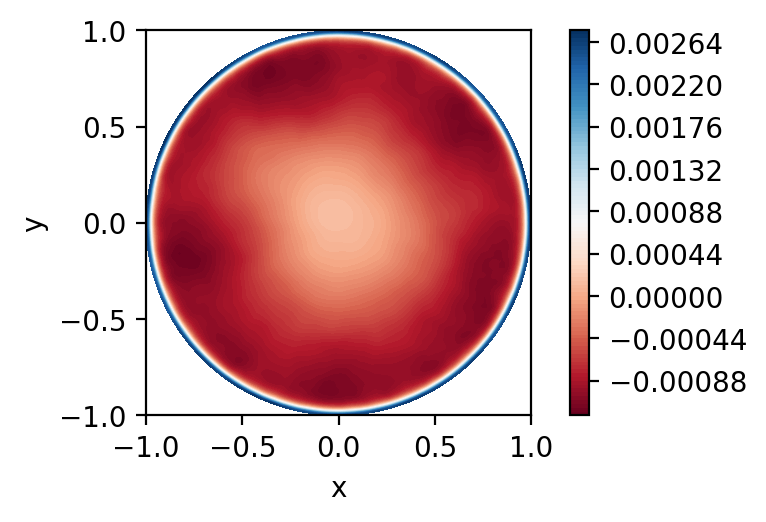

In [4]:
from pysemtools.io.ppymech.neksuite import pynekread
from pysemtools.datatypes.msh import Mesh
from pysemtools.datatypes.field import FieldRegistry

msh = Mesh(comm, create_connectivity=True)
fld = FieldRegistry(comm)
pynekread(stats_dir+stats2D_filename, comm, data_dtype=np.single, msh=msh)

fld.add_field(comm, "w", file_type="fld", file_name=stats_dir+stats2D_filename, file_key="pres", dtype=np.single)

fig, ax = plt.subplots(figsize=(5, 2.5), dpi = 200)
c = ax.tricontourf(msh.x.flatten(), msh.y.flatten() ,fld.registry["w"].flatten(), levels=100, cmap="RdBu")
fig.colorbar(c)
ax.set_aspect('equal')
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

## Extrude the 2D data

The scripts we have compiled work in 3D fields. Our data has already been averaged in the streamwise direction by the solver. To fix that, we will extrude our data into a 3d field with one element.

In [5]:
from pysemtools.postprocessing.statistics.RS_budgets import convert_2Dstats_to_3D

stats3D_filename = "batch_fluid_stats_3D0.f00000"
convert_2Dstats_to_3D(
    stats_dir+"/"+stats2D_filename,
    stats_dir+"/"+stats3D_filename,
    datatype='single')

Number of scalar fields: 40
fields in the give file:  ['vel_0', 'vel_1', 'pres', 'temp', 'scal_0', 'scal_1', 'scal_2', 'scal_3', 'scal_4', 'scal_5', 'scal_6', 'scal_7', 'scal_8', 'scal_9', 'scal_10', 'scal_11', 'scal_12', 'scal_13', 'scal_14', 'scal_15', 'scal_16', 'scal_17', 'scal_18', 'scal_19', 'scal_20', 'scal_21', 'scal_22', 'scal_23', 'scal_24', 'scal_25', 'scal_26', 'scal_27', 'scal_28', 'scal_29', 'scal_30', 'scal_31', 'scal_32', 'scal_33', 'scal_34', 'scal_35', 'scal_36', 'scal_37', 'scal_38']


/home/adperez/software/pySEMTools/pysemtools/postprocessing/statistics/RS_budgets.py:138: UserWarning: The number of scalar fields above 39 is not supported. This was done to make converted 2D statistics files consistent! Limiting the number to 39...
  warnings.warn("The number of scalar fields above 39 is not supported. "+
/home/adperez/software/pySEMTools/pysemtools/postprocessing/statistics/RS_budgets.py:228: UserWarning: The s39 field (z-velocity) was not removed from the file. Be careful with potential inconsistencies!
  warnings.warn('The s39 field (z-velocity) was not removed from the file. '+


## Calculate extra fields

As mentioned before, the solver already calculates the statistics of 44 fields. These are then used in this step to calculate 99 more that will ultimately be used to obtain the budgets.

In [6]:
from pysemtools.postprocessing.statistics.RS_budgets import compute_and_write_additional_pstat_fields

fname_mesh       = stats3D_filename
fname_mean       = stats3D_filename
fname_stat       = fname_mean
which_code       = "neko"
nek5000_stat_type = ""
if_do_dssum_on_derivatives = False          # whether to do dssum to computed derivatives... strongly NOT recommended

compute_and_write_additional_pstat_fields(
    stats_dir,
    fname_mesh,
    fname_mean,
    fname_stat,
    if_write_mesh=True,
    which_code=which_code,
    nek5000_stat_type=nek5000_stat_type,
    if_do_dssum_on_derivatives=if_do_dssum_on_derivatives)

working on: UU
working on: VV
working on: WW
working on: UV
working on: UW
working on: VW
working on: UUU
working on: VVV
working on: WWW
working on: UUV
working on: UUW
working on: UVV
working on: UVW
working on: VVW
working on: UWW
working on: VWW
-------As a great man once said: run successful: dying ...


## Interpolate the data

We now have the data in the spectral element mesh. For some operations, like averaging, having everything in a polar mesh would make everything easier. For that, we introduce interpolation steps. The deep explanations on how interpolation works are in dedicated examples. Here we just make use of the appropiate functions.

### Generate a set of points to interpolate into

First we generate a set of query points.

In [7]:
def geometric_stretching(dx0,stretching,dxmax,xmax):
    import numpy as np

    dx_base     = dx0 * (stretching**np.linspace(0,1000,1001))
    x_base      = np.cumsum( dx_base )
    N_inrange   = np.sum( x_base<=xmax )
    x_base      = x_base[0:N_inrange]
    x_base      = x_base/np.max(x_base)

    x                = np.zeros(N_inrange+1)
    x[0]             = 0.0
    x[1:N_inrange+1] = x_base

    return x

#%% convert polar to Cartesian coordinates
def polar_to_cartesian(R,T):
    import numpy as np

    X = R * np.cos(T)
    Y = R * np.sin(T)

    return X,Y

def user_defined_interpolating_points():
    import numpy as np
    import pysemtools.interpolation.pointclouds as pcs
    import pysemtools.interpolation.utils as interp_utils

    print("generate interpolation points")

    # Create the coordinates of the plane you want
    theta_bbox  = [0.0, 2.*np.pi]

    ntheta  = 168*7
    nz      = 1

    # add one point to exclude since periodic
    theta = np.linspace( theta_bbox[0] , theta_bbox[1] , ntheta+1 )
    # z     = np.linspace( z_bbox[0] , z_bbox[1] , nz+1 )
    
    # exclude last points since periodic
    theta = .5 * ( theta[0:ntheta]+theta[1:] )
    z     = 0
    # z     = .5 * ( z[0:nz]+z[1:])

    re_tau      = 1000.
    dr0         = .3/re_tau
    stretching  = 1.05
    drmax       = 15./re_tau
    rmax        = 1.0

    r_base      = geometric_stretching(dr0,stretching,drmax,rmax)
    #r_base[0]   = 0.1/re_tau    # to avoid potential issues when maping to the exact walls
    r_base      = 1-r_base
    nr          = r_base.size
    Nstruct     = [nr, ntheta, nz]
    print('Nstruct=', Nstruct)

    R,T,Z = np.meshgrid(r_base, theta, z, indexing="ij")

    # r_crit  = 0.8
    # kplus   = 40.0
    # Lz      = 4.0 * np.pi
    # nmodesZ = 1.0 * 42
##    R,T,Z   = shift_points_to_cosine_pipe(R,T,Z , re_tau,r_crit,kplus,Lz,nmodesZ )
    X,Y     = polar_to_cartesian(R,T)

    xyz = interp_utils.transform_from_array_to_list(nr, ntheta, nz, [X, Y, Z])

    return xyz, Nstruct

# Call the functions

# Call the functions
# NOTE: this should either be called from rank 0 only and then propoerly distributed into mpi ranks
#       or each rank should generate its own points
if comm.Get_rank() == 0:
    xyz , Nstruct_from_function = user_defined_interpolating_points()
else:
    xyz = 0

generate interpolation points
Nstruct= [105, 1176, 1]


### Perform the interpolation

Note that finding the points always takes a while.

In [8]:
from pysemtools.postprocessing.statistics.RS_budgets import interpolate_all_stat_and_pstat_fields_onto_points

if_do_dssum_before_interp        = False    # whether to do dssum before interpolation
if_create_boundingBox_for_interp = False    # whether to create a bounding box around the point cloud
                                            # useful for cases where there is a cluster of points somewhere
if_pass_points_to_rank0_only     = True     # pass all points to rank0 only. this is to avoid passing duplicate points
                                            # alternative is for each rank to generate its own points only, but that is too complex

interpolate_all_stat_and_pstat_fields_onto_points(
    stats_dir,
    fname_mesh,
    fname_mean,
    fname_stat,
    xyz,
    which_code=which_code,
    nek5000_stat_type=nek5000_stat_type,
    if_do_dssum_before_interp=if_do_dssum_before_interp,
    if_create_boundingBox_for_interp=if_create_boundingBox_for_interp,
    if_pass_points_to_rank0_only=if_pass_points_to_rank0_only
)


----------- working on file:  ../data/sem_data/statistics/pipe_nelv_5000//batch_fluid_stats_3D0.f00000
Number of scalar fields: 40
---working on field  0 from a total of  44
---working on field  1 from a total of  44
---working on field  2 from a total of  44
---working on field  3 from a total of  44
---working on field  4 from a total of  44
---working on field  5 from a total of  44
---working on field  6 from a total of  44
---working on field  7 from a total of  44
---working on field  8 from a total of  44
---working on field  9 from a total of  44
---working on field  10 from a total of  44
---working on field  11 from a total of  44
---working on field  12 from a total of  44
---working on field  13 from a total of  44
---working on field  14 from a total of  44
---working on field  15 from a total of  44
---working on field  16 from a total of  44
---working on field  17 from a total of  44
---working on field  18 from a total of  44
---working on field  19 from a total of  44

## Generate relevant plots (in serial)

We now read the data that has been interpolated and generate the plots. We make a particular note here that this region of the example can only be executed in serial. Everything before can be done in parallel with MPI support.

In [ ]:
#%% load the required functions
path_to_files   = "./" 

# pipe flow at Re_tau=1000
Reynolds_number     = 1 / 0.0000530504 

If_convert_to_single = True     # converts the statiscs/budegts data into single precision
If_average           = True     # calculate average in space

if comm.Get_rank() == 0:
    Nstruct     = Nstruct_from_function # structured formation of the interpolation mesh

fname_averaged  = 'averaged_and_renamed_interpolated_fields.hdf5'   # name of the hdf5 written after rehsaping into structured formation and averaging in space
fname_budget    = "pstat3d_format.hdf5"     # name of the hdf5 file containing calculated budgets



### Perform averaging (Optional)

In some cases, more averaging in some particular direction might be needed. IN this example we show how that could be done. In this example, axis 2 has only one point, therefore this averaging operation does nothing. We keep it here to show one possible operation to be done to the fields.

In this particular case all the function does is to replicate all the data into 8 points in the z direction, to also assume that we have a 3d field when performing the rotations to be performed later.

In [10]:
# NOTE: the use of Reynolds number assumes all fields are in non-dimensional form
#       this should be fixed later
from pysemtools.postprocessing.statistics.RS_budgets_interpolatedPoints_notMPI import read_interpolated_stat_hdf5_fields

def av_func(x):
    import numpy as np
    return np.mean(x, axis=2, keepdims=True) * np.ones((*x.shape[:2], 8,x.shape[3]))

if comm.Get_rank() == 0:
    read_interpolated_stat_hdf5_fields( 
            path_to_files , 
            Reynolds_number , 
            If_average , 
            If_convert_to_single , 
            Nstruct , 
            av_func , 
            output_fname = fname_averaged
            )

reading xyz coordinates...
Done in 0.00 seconds.
reading the 44 statistics fields...
Done in 0.07 seconds.
reading the additional 99 fields...
Finished reading all fields.
Done in 0.17 seconds.
Converting arrays into single precision...
Conversion complete.
Done in 0.01 seconds.
Reshaping into arrays...
Reshaping complete.
Done in 0.00 seconds.
Permuting arrays into the original shape...
Permutation complete.
Done in 0.00 seconds.
Taking the user-specified average using function av_func...
Averaging complete.
Done in 0.63 seconds.
Saving the data in HDF5 format...
Done in 1.01 seconds.
Data saved successfully in HDF5 format.


### Calculate the budgets

Use the interpolated aditional fields to finally calculate the budget terms in cartesian coordinates.

In [ ]:
import h5py
print("CWD:", os.getcwd())
print("path_to_files:", repr(path_to_files))
print("fname_averaged:", repr(fname_averaged))

full_path = os.path.join(path_to_files, fname_averaged)
print("Full averaged file path:", os.path.abspath(full_path))
print("File exists?", os.path.exists(full_path))

if os.path.exists(full_path):
    with h5py.File(full_path, "r") as f:
        keys = list(f.keys())
        print("Datasets/groups in averaged file:", keys)
        print("'XYZ_struct' in file?", "XYZ_struct" in keys)

In [11]:

# NOTE: budgets are done in Cartesian cooridnates
# NOTE: this part uses Re number, meaning it assumes fields are in non-dimensional form
from pysemtools.postprocessing.statistics.RS_budgets_interpolatedPoints_notMPI import calculate_budgets_in_Cartesian
if comm.Get_rank() == 0:
    calculate_budgets_in_Cartesian(
            path_to_files   = path_to_files , 
            input_filename  = fname_averaged ,
            output_filename = fname_budget )

Reynolds number =  18849.99924600003
--------------working on XYZ coordinates...
Number of points:  (105, 1176, 8)
Done in 0.01 seconds.
--------------working on mean velocities...
Done in 0.02 seconds.
--------------working on Reynolds stresses...
Done in 0.07 seconds.
--------------working on pressure and its moments...
Done in 0.18 seconds.
--------------working on tripple products...
Done in 0.47 seconds.
--------------working on velocity kurtosis...
Done in 0.19 seconds.
--------------working on velocity gradients...
Time taken: 0.05 seconds
--------------working on momentum convection terms...
Time taken: 0.09 seconds
--------------working on the residual momentum convection terms...
Time taken: 0.07 seconds
--------------working on momentum pressure terms...
Time taken: 0.02 seconds
--------------working on production terms...
Time taken: 0.40 seconds
--------------working on convection terms...
Time taken: 0.76 seconds
--------------working on momentum turbulent diffusion terms

### Rotate and perform averages

All the tensors calculated can be rotated into cylindrical coordinates, which match better the pipe. One can the perfomr azimuthal averages and plot the values.

Here we show the values from the provided data with those of a reference simulation.

Re_tau =  996.6628834418224
(104, 1176, 8)
(104,)


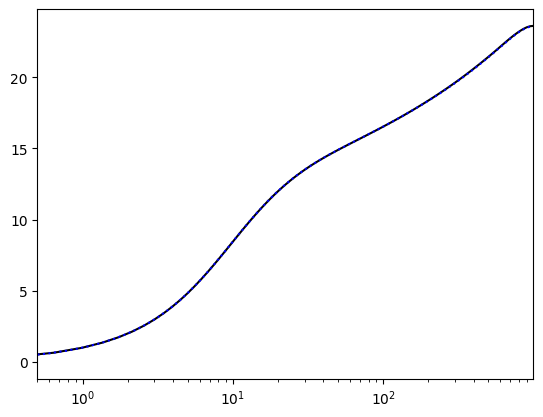

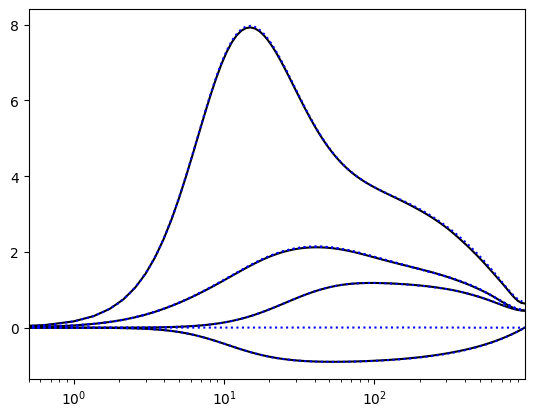

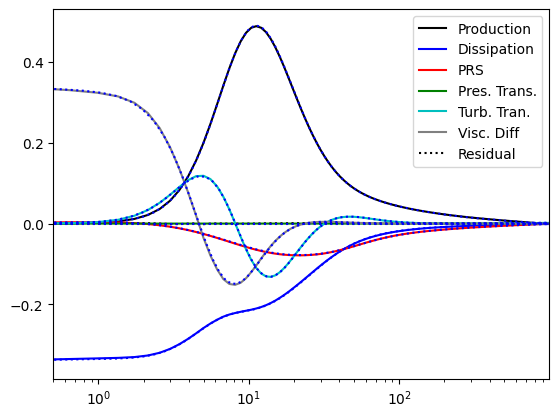

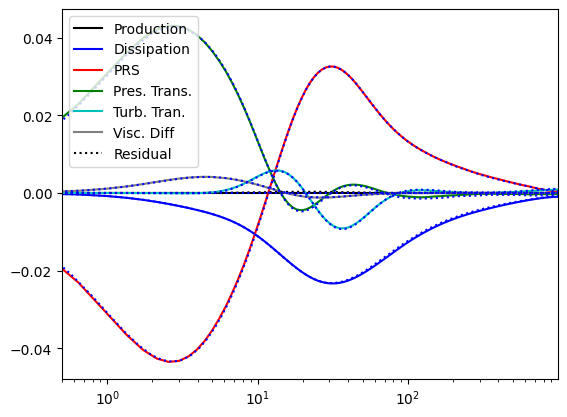

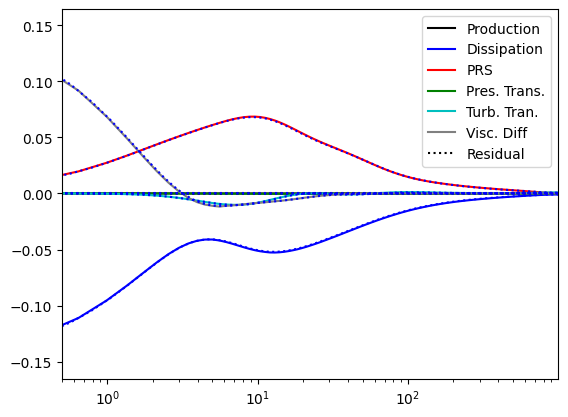

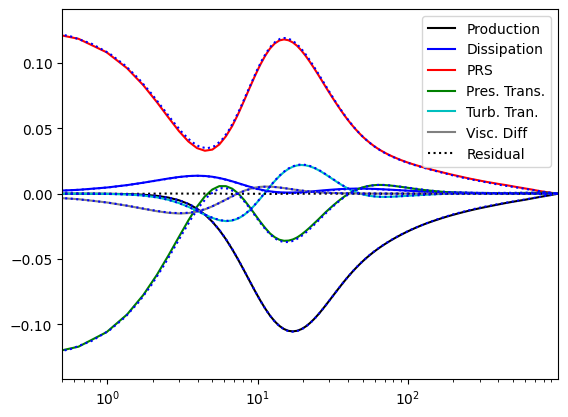

In [12]:

def define_cylindrical_coord_system_vectors(XYZ):
    import numpy as np

    # unit vector in direction 1 is along z
    v1 = np.zeros_like(XYZ) 
    v1[...,2] = 1.0

    # unit vector in direction 2 is along the wall normal
    # this is based on dimension one of XYZ corresponding to r
    v2 = XYZ[-1,...]-XYZ[0,...]
    v2 = v2/np.sqrt(np.sum(v2**2,axis=-1,keepdims=True))
    v2 = v2 * np.ones_like(v1)

    # the last vector in a right-handed orthogonal coordinate system is the cross product of the first two
    v3 = np.cross(v1,v2,axis=3)

    return v1,v2,v3

# NOTE: not properly scripted yet, for demonstraiton purposes only
import h5py
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from pysemtools.postprocessing.statistics.tensor_manipulations import rotate_6c2D_tensor
from pysemtools.postprocessing.statistics.tensor_manipulations import rotate_vector
from pysemtools.postprocessing.statistics.tensor_manipulations import define_rotation_tensor_from_vectors
from pysemtools.postprocessing.statistics.tensor_manipulations import rotate_2D_tensor

path_to_refdata     = stats_dir+"/ref_data/"
fnames_refdata_vel  = 'PIPE_Re1K_MEAN.dat'
fnames_refdata_RS   = 'PIPE_Re1K_RMS.dat'
fnames_refdata_buds = ['PIPE_Re1K_RSTE_uzuz.dat','PIPE_Re1K_RSTE_urur.dat',
                    'PIPE_Re1K_RSTE_utut.dat','PIPE_Re1K_RSTE_uruz.dat']

input_filename = path_to_files+'/'+fname_budget

if comm.Get_rank() == 0:
    
    with h5py.File(input_filename, "r") as input_file:
        XYZ         = np.array(input_file['XYZ'][:])
        v1,v2,v3    = define_cylindrical_coord_system_vectors(XYZ)
        Q           = define_rotation_tensor_from_vectors(v1,v2,v3)
        Qtrans      = np.transpose(Q,axes=(0,1,2 , 4,3 ))
        Nxyz        = XYZ.shape

        UVW     = np.array(input_file['UVW'][:])
        Rij     = np.array(input_file['Rij'][:])  
        dUidXj  = np.array(input_file['dUidXj'][:])

        Prod_ij         = np.array(input_file['Prod_ij'][:]) 
        Diss_ij         = np.array(input_file['Diss_ij'][:])
        PRS_ij          = np.array(input_file['PRS_ij'][:]) 
        Conv_ij         = np.array(input_file['Conv_ij'][:]) 
        PressTrans_ij   = np.array(input_file['PressTrans_ij'][:]) 
        TurbTrans_ij    = np.array(input_file['TurbTrans_ij'][:]) 
        VelPressGrad_ij = np.array(input_file['VelPressGrad_ij'][:]) 
        ViscDiff_ij     = np.array(input_file['ViscDiff_ij'][:])

        UVW     = rotate_vector(UVW,Qtrans,Q)
        UVW     = np.mean( np.mean( UVW ,axis=1 ),axis=1)

        Rij             = rotate_6c2D_tensor(Rij,Qtrans,Q)
        Prod_ij         = rotate_6c2D_tensor(Prod_ij,Qtrans,Q)
        Diss_ij         = rotate_6c2D_tensor(Diss_ij,Qtrans,Q)
        PRS_ij          = rotate_6c2D_tensor(PRS_ij,Qtrans,Q)
        Conv_ij         = rotate_6c2D_tensor(Conv_ij,Qtrans,Q)
        PressTrans_ij   = rotate_6c2D_tensor(PressTrans_ij,Qtrans,Q)
        TurbTrans_ij    = rotate_6c2D_tensor(TurbTrans_ij,Qtrans,Q)
        VelPressGrad_ij = rotate_6c2D_tensor(VelPressGrad_ij,Qtrans,Q)
        ViscDiff_ij     = rotate_6c2D_tensor(ViscDiff_ij,Qtrans,Q)
        

        Rij             = np.mean( np.mean( Rij ,axis=1 ),axis=1)
        Prod_ij         = np.mean( np.mean( Prod_ij ,axis=1 ),axis=1)
        Diss_ij         = np.mean( np.mean( Diss_ij ,axis=1 ),axis=1)
        PRS_ij          = np.mean( np.mean( PRS_ij ,axis=1 ),axis=1)
        Conv_ij         = np.mean( np.mean( Conv_ij ,axis=1 ),axis=1)
        PressTrans_ij   = np.mean( np.mean( PressTrans_ij ,axis=1 ),axis=1)
        TurbTrans_ij    = np.mean( np.mean( TurbTrans_ij ,axis=1 ),axis=1)
        VelPressGrad_ij = np.mean( np.mean( VelPressGrad_ij ,axis=1 ),axis=1)
        ViscDiff_ij     = np.mean( np.mean( ViscDiff_ij ,axis=1 ),axis=1)

        Res_ij = Prod_ij + Diss_ij + PRS_ij + Conv_ij + PressTrans_ij + TurbTrans_ij + ViscDiff_ij 
        
        dUidXj  = np.reshape( dUidXj , (Nxyz[0],Nxyz[1],Nxyz[2],3,3) , order="F" )
        dUidXj  = rotate_2D_tensor(dUidXj , Qtrans,Q)
        dUidXj  = np.mean( np.mean( dUidXj ,axis=1 ),axis=1)


        # Rer     = 1 / 0.0000530504 # 
        Rer = np.float64(input_file['Rer_here'])

        fluid_nu        = 1/Rer 
        # print(dUidXj[0,...])
        tauW_over_rho   = fluid_nu * dUidXj[0,1,0]
        u_tau           = np.sqrt(tauW_over_rho)
        delta_nu        = fluid_nu / u_tau
        Re_tau          = 1/delta_nu
        print('Re_tau = ', Re_tau )

        dr = XYZ[1:,...]-XYZ[:-1,...]
        dr = np.sqrt( np.sum(dr**2 , axis=-1) )
        r = np.cumsum(dr,axis=0)
        print( np.shape(r))
        r = r[:,0,0]
        print( np.shape(r))
        rtmp = r
        r    = np.zeros(Nxyz[0])
        r[1:] = rtmp

        yplus = r/delta_nu

        plt.figure(1)
        plt.semilogx(yplus,UVW[:,0] /u_tau   ,'k')
        #df = pd.read_csv(path_to_refdata+'/'+fnames_refdata_vel, delim_whitespace=True, header=None) 
        df = pd.read_csv(path_to_refdata+'/'+fnames_refdata_vel, sep='\s+', header=None) 
        plt.semilogx(df.iloc[:,2],df.iloc[:,5]  ,':b')
        plt.xlim((.5,Re_tau))
        plt.savefig(path_to_files+'/'+'Uplus')

        plt.figure(2)
        plt.semilogx(yplus,Rij[:,:4] /u_tau**2  ,'k')
        #df = pd.read_csv(path_to_refdata+'/'+fnames_refdata_RS, delim_whitespace=True, header=None) 
        df = pd.read_csv(path_to_refdata+'/'+fnames_refdata_RS, sep='\s+', header=None) 
        plt.semilogx(df.iloc[:,2],df.iloc[:,3:]  ,':b')
        plt.xlim((.5,Re_tau))
        plt.savefig(path_to_files+'/'+'RSplus')
        
        for k in range(4):
            plt.figure(11+k)
            plt.semilogx(yplus,Prod_ij[:,k] /(u_tau**3/delta_nu)       ,'k')
            plt.semilogx(yplus,Diss_ij[:,k] /(u_tau**3/delta_nu)       ,'b')
            plt.semilogx(yplus,PRS_ij[:,k] /(u_tau**3/delta_nu)        ,'r')
            plt.semilogx(yplus,PressTrans_ij[:,k] /(u_tau**3/delta_nu) ,'g')
            plt.semilogx(yplus,TurbTrans_ij[:,k] /(u_tau**3/delta_nu)  ,'c')
            plt.semilogx(yplus,ViscDiff_ij[:,k] /(u_tau**3/delta_nu)   ,'grey')
            plt.semilogx(yplus,Res_ij[:,k] /(u_tau**3/delta_nu)        ,':k')
            if k<4:
                df = pd.read_csv(path_to_refdata+'/'+fnames_refdata_buds[k], sep='\s+', header=None) 
                if not k==3:
                    plt.semilogx(df.iloc[:,2],df.iloc[:,3:]  ,':b')
                else:
                    plt.semilogx(df.iloc[:,2],-df.iloc[:,3:]  ,':b')
            plt.xlim((.5,Re_tau))
            plt.legend(('Production','Dissipation','PRS','Pres. Trans.','Turb. Tran.','Visc. Diff','Residual'))
            plt.savefig(path_to_files+'/'+'budget')

    plt.show()

Now we are done! From simulation outputs to results!